In [1]:
# 调用相关库
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import pandas as pd
from math import sqrt
import random
from numpy import concatenate
import matplotlib.pyplot as plt
import numpy as np
import scipy as spy
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pandas import DataFrame
from pandas import concat
from scipy.io import savemat,loadmat
import numpy
import os
import copy
import math
from sklearn.svm import SVR  
from scipy.spatial.distance import cdist
from numpy import dot, exp

In [2]:
# 转换成监督数据，将每个特征转换成21列数据，20->1，20组预测一组
def series_to_supervised(data, n_in=20, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]  #计算特征的数量
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    # 将20组输入数据依次向下移动20,19,...3,2,1行，将数据加入cols列表（技巧：(n_in, 0, -1)中的-1指倒序循环，步长为1）
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    # 将一组输出数据加入cols列表（技巧：其中i=0）
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # cols列表(list)中现在有21块经过下移后的数据(即：df(-20),df(-19),...df(-2),df(-1),df)，将四块数据按列 并排合并
    agg = pd.concat(cols, axis=1)
    # 给合并后的数据添加列名
    agg.columns = names
    # print(agg)
    # 删除NaN值列
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
values=pd.read_csv('train.csv').values[:5000,-1]
# values
# dates=df.index.values
n_features=1 #特征数量

In [4]:
close=values
# close = data[:,0]
close.shape

(5000,)

In [5]:
import numpy as np
import math

def VMD(signal, alpha, tau, K, DC, init, tol):
    # ---------------------
    #  signal  - the time domain signal (1D) to be decomposed
    #  alpha   - the balancing parameter of the data-fidelity constraint
    #  tau     - time-step of the dual ascent ( pick 0 for noise-slack )
    #  K       - the number of modes to be recovered
    #  DC      - true if the first mode is put and kept at DC (0-freq)
    #  init    - 0 = all omegas start at 0
    #                     1 = all omegas start uniformly distributed
    #                     2 = all omegas initialized randomly
    #  tol     - tolerance of convergence criterion; typically around 1e-6
    #
    #  Output:
    #  -------
    #  u       - the collection of decomposed modes
    #  res     - residual
    #  u_hat   - spectra of the modes
    #  omega   - estimated mode center-frequencies
    

    
    # Period and sampling frequency of input signal
    save_T=len(signal)
    fs=1/float(save_T)

    # extend the signal by mirroring
    T=save_T
    # print(T)
    f_mirror=np.zeros(2*T)
    #print(f_mirror)
    f_mirror[0:T//2]=signal[T//2-1::-1]
    # print(f_mirror)
    f_mirror[T//2:3*T//2]= signal
    # print(f_mirror)
    f_mirror[3*T//2:2*T]=signal[-1:-T//2-1:-1]
    # print(f_mirror)
    f=f_mirror
    # print('f_mirror')
    # print(f_mirror)
    # print('-------')

    # Time Domain 0 to T (of mirrored signal)
    T=float(len(f))
    # print(T)
    t=np.linspace(1/float(T),1,int(T),endpoint=True)
    # print(t)

    # Spectral Domain discretization
    freqs=t-0.5-1/T
    # print(freqs)
    # print('-----')
    # Maximum number of iterations (if not converged yet, then it won't anyway)
    N=500

    # For future generalizations: individual alpha for each mode
    Alpha=alpha*np.ones(K,dtype=complex)
    # print(Alpha.shape)
    # print(Alpha)
    # print('-----')

    # Construct and center f_hat
    f_hat=np.fft.fftshift(np.fft.fft(f))
    # print('f_hat')
    # print(f_hat.shape)
    # print(f_hat)
    # print('-----')
    f_hat_plus=f_hat
    f_hat_plus[0:int(int(T)/2)]=0
    # print('f_hat_plus')
    # print(f_hat_plus.shape)
    # print(f_hat_plus)
    # print('-----')
    # matrix keeping track of every iterant // could be discarded for mem
    u_hat_plus=np.zeros((N,len(freqs),K),dtype=complex)
    # print('u_hat_plus')
    # print(u_hat_plus.shape)
    # print(u_hat_plus)
    # print('-----')


    # Initialization of omega_k
    omega_plus=np.zeros((N,K),dtype=complex)
    # print('omega_plus')
    # print(omega_plus.shape)
    # print(omega_plus)
                        
    if (init==1):
        for i in range(1,K+1):
            omega_plus[0,i-1]=(0.5/K)*(i-1)
    elif (init==2):
        omega_plus[0,:]=np.sort(math.exp(math.log(fs))+(math.log(0.5)-math.log(fs))*np.random.rand(1,K))
    else:
        omega_plus[0,:]=0

    if (DC):
        omega_plus[0,0]=0

    # print('omega_plus')
    # print(omega_plus.shape)
    # print(omega_plus)

    # start with empty dual variables
    lamda_hat=np.zeros((N,len(freqs)),dtype=complex)

    # other inits
    uDiff=tol+2.2204e-16 #updata step
    # print('uDiff')
    # print(uDiff)
    # print('----')
    n=1 #loop counter
    sum_uk=0 #accumulator

    T=int(T)


    # ----------- Main loop for iterative updates

    while uDiff > tol and n<N:
        # update first mode accumulator
        k=1
        sum_uk = u_hat_plus[n-1,:,K-1]+sum_uk-u_hat_plus[n-1,:,0]
    #     print('sum_uk')
    #     print(sum_uk)
        #update spectrum of first mode through Wiener filter of residuals
        u_hat_plus[n,:,k-1]=(f_hat_plus-sum_uk-lamda_hat[n-1,:]/2)/(1+Alpha[k-1]*np.square(freqs-omega_plus[n-1,k-1]))
    #     print('u_hat_plus')
    #     print(u_hat_plus.shape)
    #     print(u_hat_plus[n,:,k-1])
    #     print('-----')
        
        

        #update first omega if not held at 0
        if DC==False:
            omega_plus[n,k-1]=np.dot(freqs[T//2:T],np.square(np.abs(u_hat_plus[n,T//2:T,k-1])).T)/np.sum(np.square(np.abs(u_hat_plus[n,T//2:T,k-1])))


        for k in range(2,K+1):

            #accumulator
            sum_uk=u_hat_plus[n,:,k-2]+sum_uk-u_hat_plus[n-1,:,k-1]
    #         print('sum_uk'+str(k))
    #         print(sum_uk)


            #mode spectrum
            u_hat_plus[n,:,k-1]=(f_hat_plus-sum_uk-lamda_hat[n-1,:]/2)/(1+Alpha[k-1]*np.square(freqs-omega_plus[n-1,k-1]))
    #         print('u_hat_plus'+str(k))
    #         print(u_hat_plus[n,:,k-1])
            
            #center frequencies
            omega_plus[n,k-1]=np.dot(freqs[T//2:T],np.square(np.abs(u_hat_plus[n,T//2:T,k-1])).T)/np.sum(np.square(np.abs(u_hat_plus[n,T//2:T:,k-1])))
    #         print('omega_plus'+str(k))
    #         print(omega_plus[n,k-1])
        #Dual ascent
    #     print(u_hat_plus.shape)
        lamda_hat[n,:]=lamda_hat[n-1,:]+tau*(np.sum(u_hat_plus[n,:,:],axis=1)-f_hat_plus)
    #     print('lamda_hat'+str(n))
    #     print(lamda_hat[n,:])

        #loop counter
        n=n+1

        #converged yet?
        uDiff=2.2204e-16

        for i in range(1,K+1):
            uDiff=uDiff+1/float(T)*np.dot(u_hat_plus[n-1,:,i-1]-u_hat_plus[n-2,:,i-1],(np.conj(u_hat_plus[n-1,:,i-1]-u_hat_plus[n-2,:,i-1])).conj().T)

            
        
        uDiff=np.abs(uDiff)
        # print('uDiff')
        # print(uDiff)

        
    # ------ Postprocessing and cleanup

    # discard empty space if converged early

    N=np.minimum(N,n)
    omega = omega_plus[0:N,:]

    # Signal reconstruction
    u_hat = np.zeros((T,K),dtype=complex)
    u_hat[T//2:T,:]= np.squeeze(u_hat_plus[N-1,T//2:T,:])
    # print('u_hat')
    # print(u_hat.shape)
    # print(u_hat)
    u_hat[T//2:0:-1,:]=np.squeeze(np.conj(u_hat_plus[N-1,T//2:T,:]))
    u_hat[0,:]=np.conj(u_hat[-1,:])
    # print('u_hat')
    # print(u_hat)
    u=np.zeros((K,len(t)),dtype=complex)

    for k in range(1,K+1):
        u[k-1,:]= np.real(np.fft.ifft(np.fft.ifftshift(u_hat[:,k-1])))


    # remove mirror part 
    u=u[:,T//4:3*T//4]
    u=np.real(u)
    
    res=signal-u.sum(axis=0)
    # print(u_hat.shape)
    #recompute spectrum
    u_hat = np.zeros((T//2,K),dtype=complex)

    for k in range(1,K+1):
        u_hat[:,k-1]=np.fft.fftshift(np.fft.fft(u[k-1,:])).conj().T
        
        
    return (u,u_hat,omega)

In [6]:
from scipy.fftpack import fft


alpha = 50      # moderate bandwidth constraint  
tau = 0            # noise-tolerance (no strict fidelity enforcement)  
k = 7      # 3 modes  
DC = 0             # no DC part imposed  
init = 1           # initialize omegas uniformly  
tol = 1e-7  

"""  
alpha、tau、K、DC、init、tol 六个输入参数的无严格要求； 
alpha 带宽限制 经验取值为 抽样点长度 1.5-2.0 倍； 
tau 噪声容限 ；
K 分解模态（IMF）个数； 
DC 合成信号若无常量，取值为 0；若含常量，则其取值为 1； 
init 初始化 w 值，当初始化为 1 时，均匀分布产生的随机数； 
tol 控制误差大小常量，决定精度与迭代次数
"""

u, u_hat, omega = VMD(close, alpha, tau, k, DC, init, tol)  



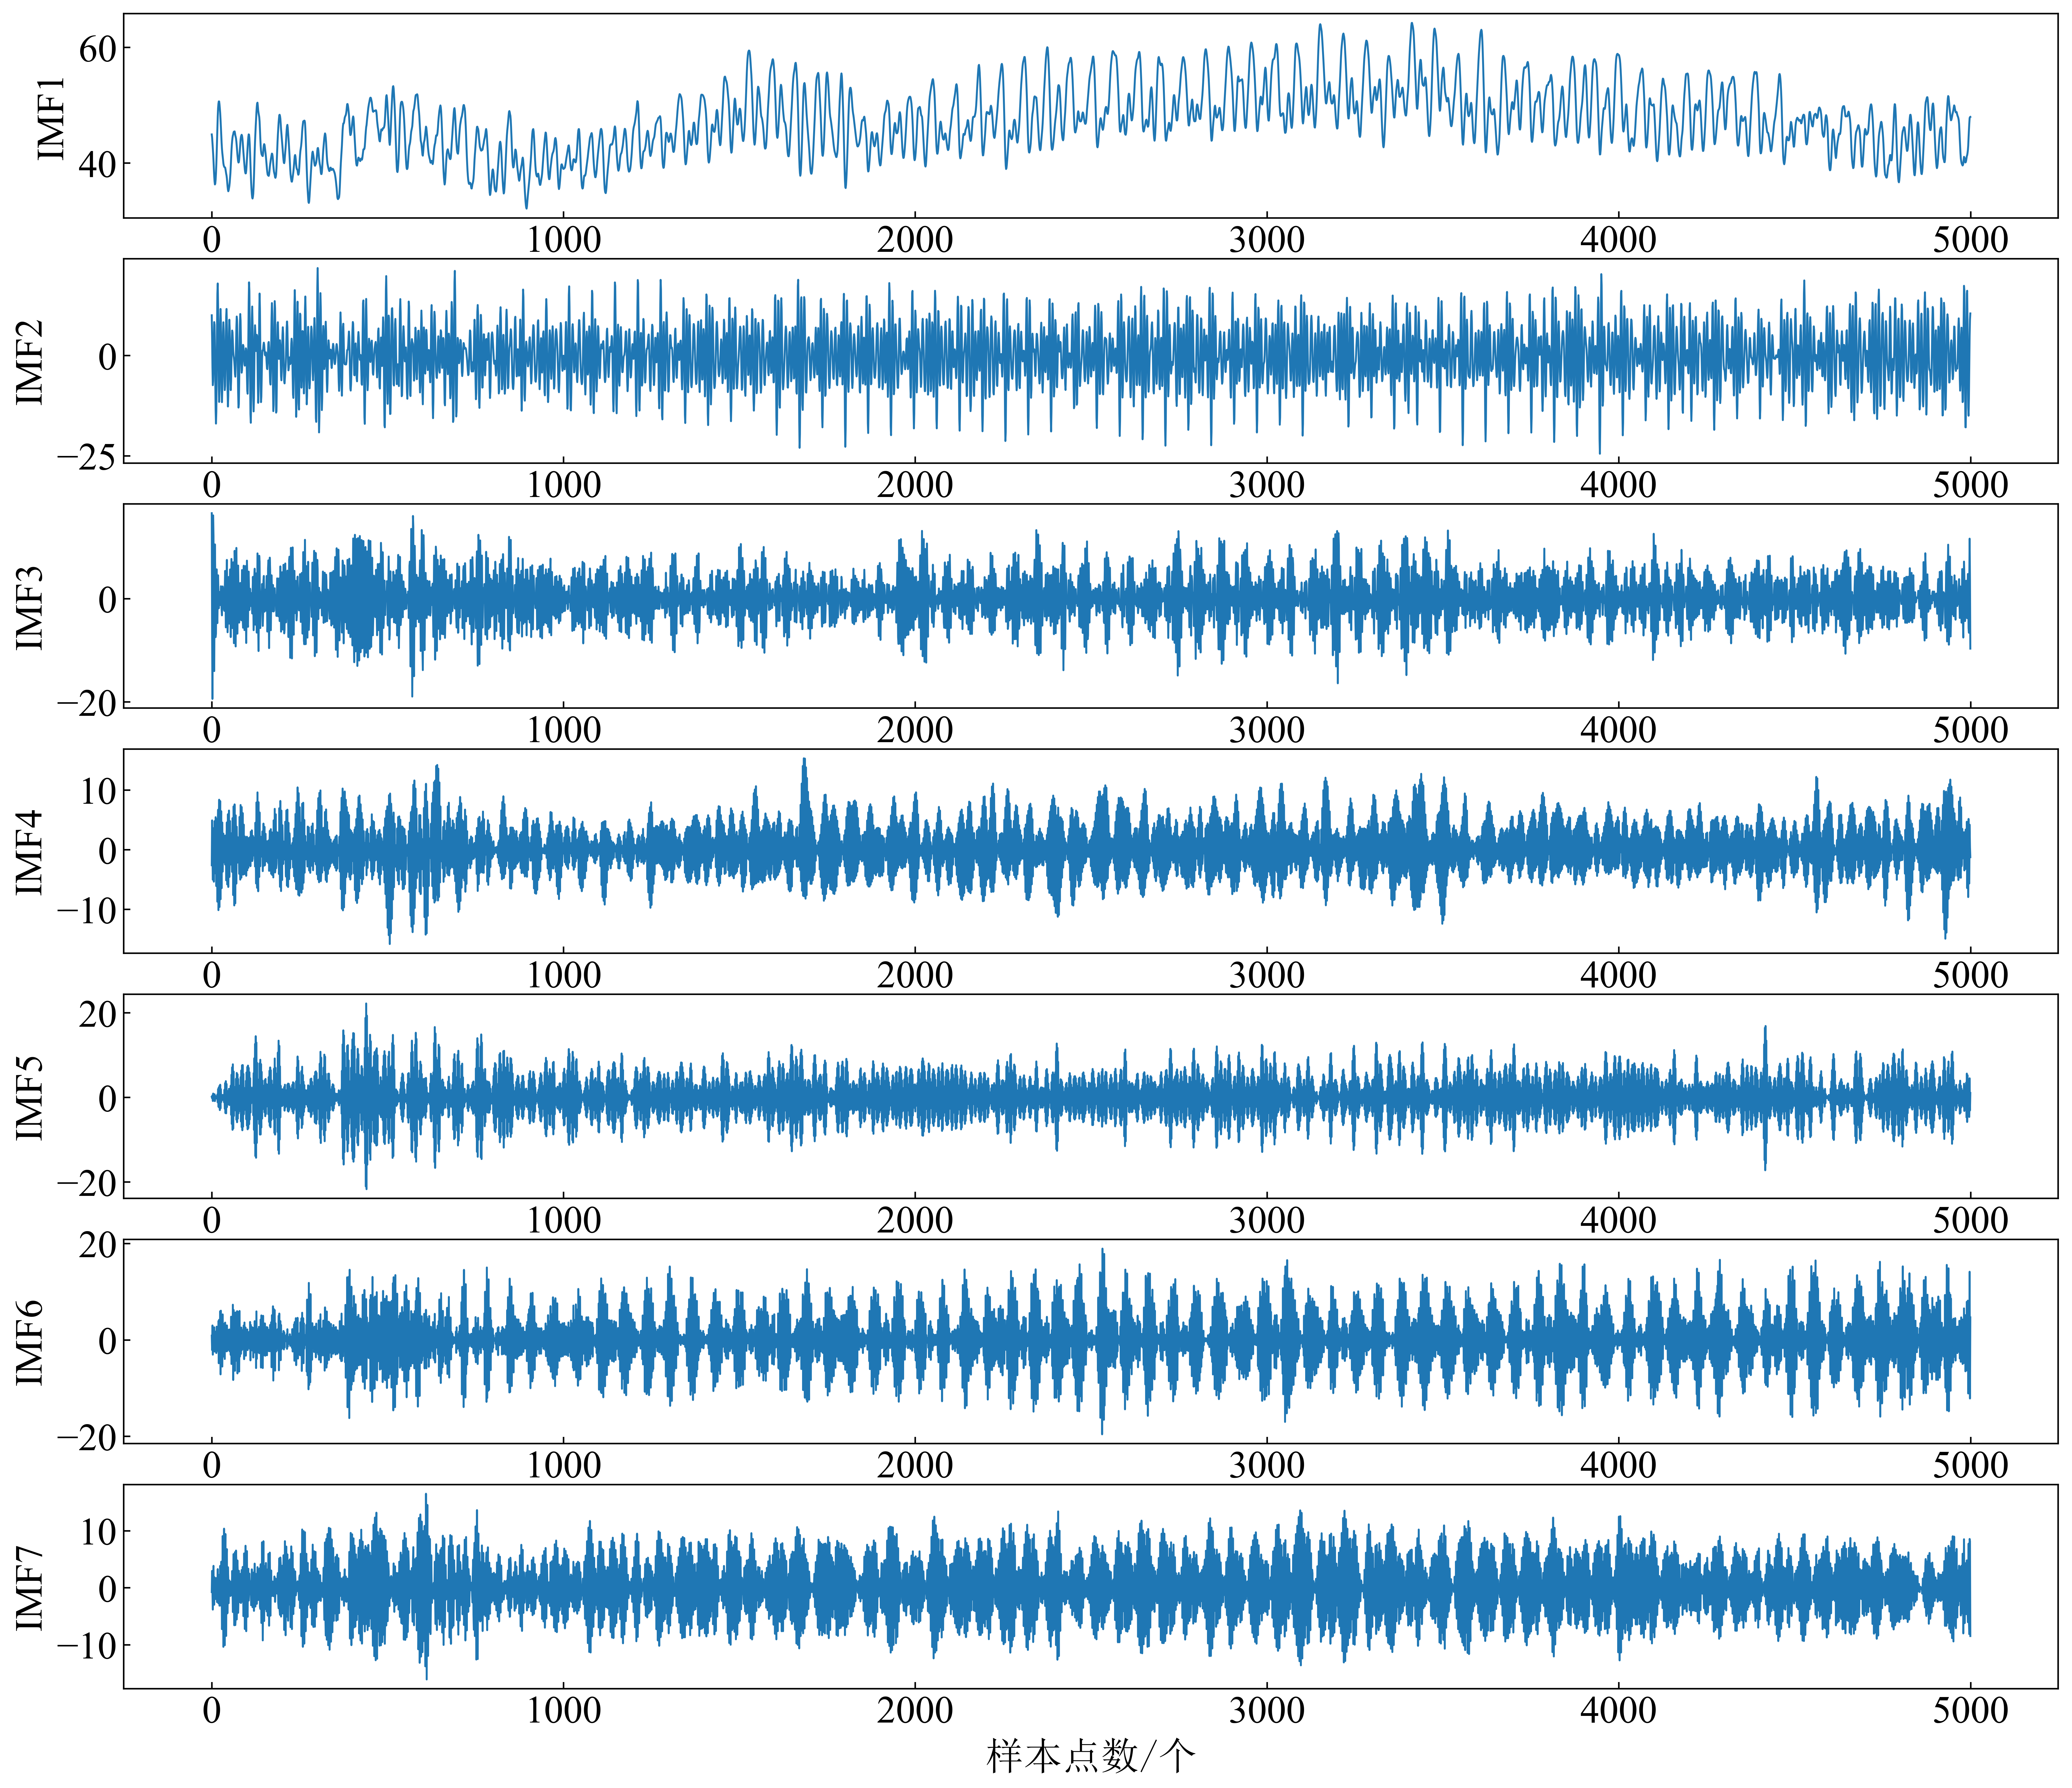

In [7]:
from matplotlib import rcParams

config = {
    "font.family":'serif',
    "font.size": 20,
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

plt.rcParams['xtick.direction'] = 'in'#将x周的刻度线方向设置向内
plt.rcParams['ytick.direction'] = 'in'#将y轴的刻度方向设置向内
plt.figure(figsize=(18,16), dpi=500)
for i in range(k):

   
    plt.subplot(k,1,i+1)
    plt.plot(u[i,:], linewidth=1)
    plt.xticks(fontproperties = 'Times New Roman')
    plt.yticks(fontproperties = 'Times New Roman')
    plt.xlabel("样本点数/个",fontdict={'family' : 'SimSun'})
    plt.ylabel('IMF{}'.format(i+1),fontdict={'family' : 'Times New Roman'})
# plt.savefig('123.svg',format='svg')

In [8]:
class DELM(object):

    def __init__(self, input_size,hidden_sizes,output_size,C,TF):
        # 初始化
        '''
            input_size:输入层节点数
            hidden_sizes:各隐含层节点数，也是各elm-ae的隐含层节点数
            output_size:输出层节点数
            C ： L2 正则化系数
            TF： 激活函数
        '''
        self._sizes = hidden_sizes
        self._l2penalty=C
        self.TF=TF 
        self.elmae=[]
        self.w=[]
        
        for i,size in enumerate(self._sizes + [output_size]):
            
            # 采样正交随机数进行网络权重初始化
            
            if input_size>=size:
                IW=spy.linalg.orth(np.random.rand(input_size,size)*2-1)
            else:
                IW=(np.random.rand(input_size,size)*2-1).T
                IW=spy.linalg.orth(IW).T
            # bias
            B=spy.linalg.orth(np.random.rand(size,1)*2-1)
            
            self.w.append(IW)
            
            if i< len(self._sizes + [output_size])-1:
                weight={'w':IW,'b':B}
                self.elmae.append(weight)
            
            input_size = size
    #无监督预训练各个ELM-AE
    def pretrain(self,X):
        self.elm_ae_weigth_list=[]#保存训练好的elmae的输出层权重 ，用于DELM初始化
        nsample=X.shape[0]
        for i in range(len(self.elmae)):
            IW=self.elmae[i]['w']
            B=self.elmae[i]['b']
            
            bias_matrix=np.tile(B,nsample).T
            
            tempH = np.dot(X,IW)+bias_matrix
            
            if self.TF=='sigmoid':
                H = 1. / (1. + np.exp(-tempH))
                
            elif self.TF=='sin':
                H=np.sin(tempH)
            # cal the output weights by least square method
            interval=(np.dot(H.T,H)+np.eye(IW.shape[1])/self._l2penalty)
            beta = np.dot(np.dot(np.linalg.pinv(interval) ,H.T),X)
            
            
            W=np.linalg.pinv(beta)
            # W = beta.T
            self.elm_ae_weigth_list.append(W)
            X=X.dot(W)
#                
    # 将训练好的elm-ae的输出层权重用于初始化delm
    def load_from_elm_aes(self):
        for i in range(len(self._sizes)):
            self.w[i] = self.elm_ae_weigth_list[i]
        
    # Training delm
    def train(self,X,Y):
        self.load_from_elm_aes()#注释掉这句 就不会采用训练好的elm-ae输出层权重对delm进行初始化
        
        
        H=[]
        input_=X
        a=len(self._sizes)
        
        for i in range(a):
            H=np.dot(input_,self.w[i])
            input_=H

        interval=np.dot(H.T,H)+np.eye(H.shape[1])/self._l2penalty
        
        beta = np.dot(np.dot(np.linalg.pinv(interval) ,H.T),Y)
        
        self.w[-1]=beta
        
    def predict(self,teX):
        H=[]
        input_=teX
        a=len(self.w)
        
        for i in range(a):
            H=np.dot(input_,self.w[i])
            input_=H
        return H

In [9]:
def Bounds(x,lb,ub,dim):
    temp = x.copy()
    for i in range(dim):
        if temp[i]>=ub[i] or temp[i]<=lb[i]:
            temp[i] = (ub[i]-lb[i])*np.random.rand()+lb[i]
    return temp


def PSO(opts,P,T,Pt,Tt):
    max_iter=100# 迭代次数
    pN=20#
    c = -1
    d = 1
    dim = 0
    nodes_num = [opts['input_size']] + opts['hidden_sizes']  # 输入层与隐含层的节点数

    for i in range(len(nodes_num) - 1):
        dim += nodes_num[i] * nodes_num[i + 1] + nodes_num[i + 1]
    xmax = d * np.ones((dim, 1))
    xmin = c * np.ones((dim, 1))
    # pN 粒子数量
    # dim 搜索维度
    # max_iter 迭代次数
    #PSO参数设置
    w  = 1.5;c1 = 0.5;c2 = 0.5;r1 = 1.3;r2 = 1.3    
    #初始化
    X = np.zeros((pN,dim))       #所有粒子的位置和速度    
    V = np.zeros((pN,dim))    
    pbest = np.zeros((pN,dim))   #个体经历的最佳位置和全局最佳位置    
    gbest = np.zeros((1,dim))   
    p_fit = np.zeros(pN)              #每个个体的历史最佳适应值    
    fit = np.inf  
    for i in range(pN):    
        for j in range(dim):    
            X[i][j] = (xmax[j]-xmin[j])*np.random.rand() + xmin[j]
            V[i][j] = np.random.rand() 
        pbest[i] = X[i,:].copy()
        tmp = fun( X[ i, : ] ,opts,P,T,Pt,Tt)
        p_fit[i] = tmp.copy()
        if(tmp < fit):    
            fit = tmp.copy()    
            gbest = X[i].copy()        
    fitness = []    
    # 开始循环迭代
    for t in range(max_iter):  
        #种群位置与速度更新
        for i in range(pN):  
            r1=np.random.rand()
            r2=np.random.rand()
            V[i,:] = w*V[i,:] + c1*r1*(pbest[i,:] - X[i,:])+c2*r2*(gbest - X[i,:])    
            for jj in range(V.shape[1]): 
                if V[i,jj]<0 or V[i,jj]>1:
                    V[i,jj]=np.random.rand()
            X[i,:] = X[i,:] + V[i,:]
            

        for i in range(pN): #更新gbest\pbest
            X[i,:]=Bounds(X[i,:],xmin,xmax,dim);
            temp = fun(X[i,:],opts,P,T,Pt,Tt)  
            if(temp < p_fit[i]):      #更新个体最优    
                p_fit[i] = temp.copy()    
                pbest[i,:] = X[i,:].copy()    
            if(p_fit[i] < fit):  #更新全局最优    
                gbest = pbest[i,:].copy()    
                fit = p_fit[i].copy()    

        fitness.append(fit)  
        print(t+1,":",fit)
    return gbest,fitness 

In [10]:
def fun(pop,opts,P,T,Pt,Tt):
    #对麻雀传人的参数进行解码
    Net = DELM(opts['input_size'],opts['hidden_sizes'], opts['output_size'], opts['C'],opts['TF']) #construct a delm
    
    nodes= [opts['input_size']]+opts['hidden_sizes']# 输入层与隐含层的节点数

    nelmae=len(nodes)-1
    para_num=[]
    
    for i in range(nelmae):
        if i==0:
            para_num += [nodes[i]*nodes[i+1]]
        else:
            para_num += [para_num[-1]+nodes[i]*nodes[i+1]]
        para_num += [para_num[-1]+nodes[i+1]]
    
    for i in range(nelmae):
        if i==0:
            IW=pop[0:para_num[i]]
            b=pop[para_num[i]:para_num[i+1]]
        else:
            IW=pop[para_num[2*i-1]:para_num[2*i]]
            b=pop[para_num[2*i]:para_num[2*i+1]]
        
        if nodes[i]>=nodes[i+1]:
            Net.elmae[i]['w']=spy.linalg.orth(IW.reshape(nodes[i],nodes[i+1]))
        else:
            Net.elmae[i]['w']=spy.linalg.orth(IW.reshape(nodes[i],nodes[i+1]).T).T
        Net.elmae[i]['b']=spy.linalg.orth(b.reshape(-1,1))


        
    Net.pretrain(P)
    Net.train(P,T)
    output=Net.predict(Pt)
    output1=output.reshape(-1,)
    Tt1=Tt.reshape(-1,)
    fit=np.mean(np.square(output1-Tt1))
    
    return fit

(3997, 3) (3997,) (1000, 3) (1000,)
1 : 0.0030979311668870063
2 : 0.0030979311668870063
3 : 0.0030979311668870063
4 : 0.0030979311668870063
5 : 0.0030979311668870063
6 : 0.0016083762319332813
7 : 0.0007574210780688693
8 : 0.0007574210780688693
9 : 0.0007574210780688693
10 : 0.0007574210780688693
11 : 0.0007574210780688693
12 : 0.0007574210780688693
13 : 0.0007574210780688693
14 : 0.0007574210780688693
15 : 0.0007574210780688693
16 : 0.0007574210780688693
17 : 0.0007574210780688693
18 : 0.0007574210780688693
19 : 0.0007574210780688693
20 : 0.0007574210780688693
21 : 0.0007574210780688693
22 : 0.0007574210780688693
23 : 0.0007574210780688693
24 : 0.0007574210780688693
25 : 0.0007574210780688693
26 : 0.0007574210780688693
27 : 0.0007574210780688693
28 : 0.0007574210780688693
29 : 0.0007574210780688693
30 : 0.0007574210780688693
31 : 0.0007574210780688693
32 : 0.0007574210780688693
33 : 0.0007574210780688693
34 : 0.0007574210780688693
35 : 0.0007574210780688693
36 : 0.0007574210780688693
3

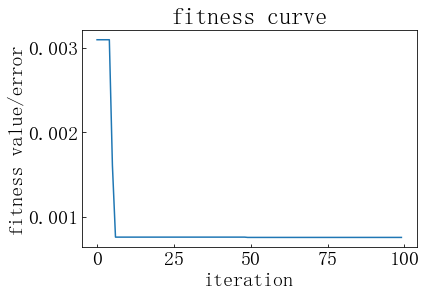

(3997, 3) (3997,) (1000, 3) (1000,)
1 : 0.06562430201017676
2 : 0.06562430201017676
3 : 0.062070395259715486
4 : 0.062070395259715486
5 : 0.062070395259715486
6 : 0.062070395259715486
7 : 0.062070395259715486
8 : 0.062070395259715486
9 : 0.062070395259715486
10 : 0.062070395259715486
11 : 0.062070395259715486
12 : 0.062070395259715486
13 : 0.062070395259715486
14 : 0.062070395259715486
15 : 0.062070395259715486
16 : 0.05706101976290196
17 : 0.0503264389167449
18 : 0.0503264389167449
19 : 0.0503264389167449
20 : 0.0503264389167449
21 : 0.0503264389167449
22 : 0.0503264389167449
23 : 0.0503264389167449
24 : 0.0503264389167449
25 : 0.0503264389167449
26 : 0.0503264389167449
27 : 0.0503264389167449
28 : 0.0503264389167449
29 : 0.0503264389167449
30 : 0.0503264389167449
31 : 0.050298040101905285
32 : 0.050298040101905285
33 : 0.050298040101905285
34 : 0.050298040101905285
35 : 0.050298040101905285
36 : 0.038267607307189935
37 : 0.038267607307189935
38 : 0.038267607307189935
39 : 0.038267607

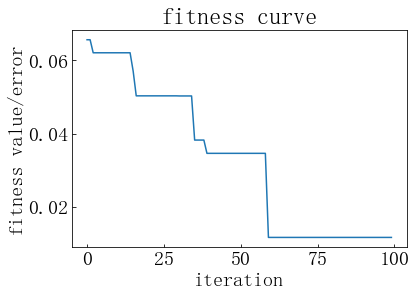

(3997, 3) (3997,) (1000, 3) (1000,)
1 : 0.0555077735310167
2 : 0.0555077735310167
3 : 0.0555077735310167
4 : 0.0555077735310167
5 : 0.0555077735310167
6 : 0.0555077735310167
7 : 0.0555077735310167
8 : 0.0555077735310167
9 : 0.0555077735310167
10 : 0.0555077735310167
11 : 0.0555077735310167
12 : 0.0555077735310167
13 : 0.0555077735310167
14 : 0.0555077735310167
15 : 0.0555077735310167
16 : 0.0555077735310167
17 : 0.0555077735310167
18 : 0.0555077735310167
19 : 0.0555077735310167
20 : 0.0555077735310167
21 : 0.0555077735310167
22 : 0.0555077735310167
23 : 0.0555077735310167
24 : 0.0555077735310167
25 : 0.0555077735310167
26 : 0.0555077735310167
27 : 0.0555077735310167
28 : 0.0555077735310167
29 : 0.0555077735310167
30 : 0.0555077735310167
31 : 0.0555077735310167
32 : 0.0555077735310167
33 : 0.0555077735310167
34 : 0.0555077735310167
35 : 0.0555077735310167
36 : 0.0555077735310167
37 : 0.0555077735310167
38 : 0.0555077735310167
39 : 0.0555077735310167
40 : 0.0555077735310167
41 : 0.055507

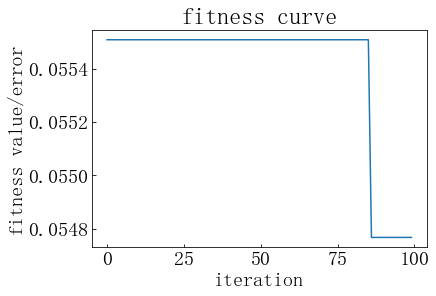

(3997, 3) (3997,) (1000, 3) (1000,)
1 : 0.07143830681904158
2 : 0.05724948927195067
3 : 0.03634704496299922
4 : 0.03634704496299922
5 : 0.03634704496299922
6 : 0.03634704496299922
7 : 0.03634704496299922
8 : 0.03634704496299922
9 : 0.03634704496299922
10 : 0.03634704496299922
11 : 0.03634704496299922
12 : 0.03634704496299922
13 : 0.03634704496299922
14 : 0.03634704496299922
15 : 0.03634704496299922
16 : 0.03634704496299922
17 : 0.03634704496299922
18 : 0.03634704496299922
19 : 0.03634704496299922
20 : 0.03634704496299922
21 : 0.03634704496299922
22 : 0.03634704496299922
23 : 0.03634704496299922
24 : 0.03634704496299922
25 : 0.03634704496299922
26 : 0.03634704496299922
27 : 0.03634704496299922
28 : 0.03634704496299922
29 : 0.03634704496299922
30 : 0.03634704496299922
31 : 0.03634704496299922
32 : 0.03634704496299922
33 : 0.03634704496299922
34 : 0.03634704496299922
35 : 0.03634704496299922
36 : 0.03634704496299922
37 : 0.03634704496299922
38 : 0.03634704496299922
39 : 0.0363470449629992

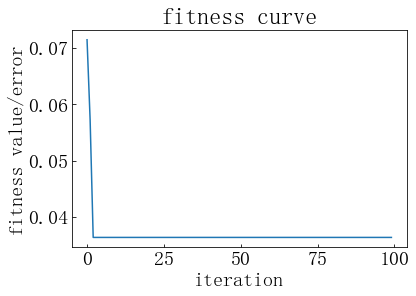

(3997, 3) (3997,) (1000, 3) (1000,)
1 : 0.00546851943770493
2 : 0.00546851943770493
3 : 0.005017012766780947
4 : 0.005017012766780947
5 : 0.005017012766780947
6 : 0.005017012766780947
7 : 0.005017012766780947
8 : 0.005017012766780947
9 : 0.005017012766780947
10 : 0.005017012766780947
11 : 0.005017012766780947
12 : 0.005017012766780947
13 : 0.005017012766780947
14 : 0.005017012766780947
15 : 0.005017012766780947
16 : 0.005017012766780947
17 : 0.005017012766780947
18 : 0.005017012766780947
19 : 0.005017012766780947
20 : 0.0045883887154736895
21 : 0.0045883887154736895
22 : 0.0045883887154736895
23 : 0.0045883887154736895
24 : 0.004487101800508915
25 : 0.0044263367751496505
26 : 0.0044263367751496505
27 : 0.0044263367751496505
28 : 0.0044263367751496505
29 : 0.0044263367751496505
30 : 0.0044263367751496505
31 : 0.0044263367751496505
32 : 0.0044263367751496505
33 : 0.0044263367751496505
34 : 0.0044263367751496505
35 : 0.0037552086208454505
36 : 0.0037552086208454505
37 : 0.0037552086208454

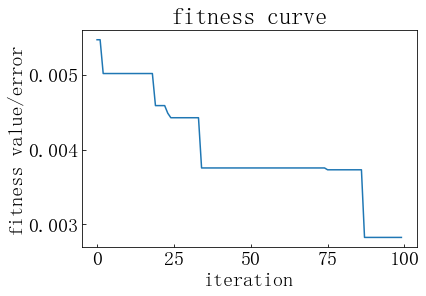

(3997, 3) (3997,) (1000, 3) (1000,)
1 : 0.028443497768344875
2 : 0.028162109082287643
3 : 0.028162109082287643
4 : 0.028162109082287643
5 : 0.028162109082287643
6 : 0.028162109082287643
7 : 0.028015906341775455
8 : 0.02594719819862926
9 : 0.02594719819862926
10 : 0.02594719819862926
11 : 0.02594719819862926
12 : 0.02594719819862926
13 : 0.025118736896148817
14 : 0.008405896197091145
15 : 0.008405896197091145
16 : 0.008405896197091145
17 : 0.008405896197091145
18 : 0.008405896197091145
19 : 0.008405896197091145
20 : 0.008405896197091145
21 : 0.008405896197091145
22 : 0.008405896197091145
23 : 0.008405896197091145
24 : 0.008405896197091145
25 : 0.008405896197091145
26 : 0.008405896197091145
27 : 0.008405896197091145
28 : 0.008405896197091145
29 : 0.008405896197091145
30 : 0.008405896197091145
31 : 0.008405896197091145
32 : 0.008405896197091145
33 : 0.008405896197091145
34 : 0.008405896197091145
35 : 0.008405896197091145
36 : 0.008405896197091145
37 : 0.008405896197091145
38 : 0.008405896

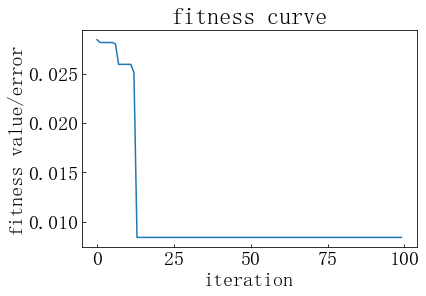

(3997, 3) (3997,) (1000, 3) (1000,)
1 : 0.03223485847788594
2 : 0.032234797230139355
3 : 0.03223471040238378
4 : 0.03223464797875359
5 : 0.03223464797875359
6 : 0.0322346018022246
7 : 0.0322346018022246
8 : 0.03223454327613655
9 : 0.03223454327613655
10 : 0.03223454327613655
11 : 0.03223454327613655
12 : 0.03223454327613655
13 : 0.03223454327613655
14 : 0.03223454327613655
15 : 0.03223454327613655
16 : 0.03223454327613655
17 : 0.03223454327613655
18 : 0.03223454327613655
19 : 0.03223454327613655
20 : 0.03223454327613655
21 : 0.03223454327613655
22 : 0.03223454327613655
23 : 0.03223454327613655
24 : 0.03223454327613655
25 : 0.03223454327613655
26 : 0.03223454327613655
27 : 0.03223454327613655
28 : 0.03223454327613655
29 : 0.03223454327613655
30 : 0.03223454327613655
31 : 0.03223454327613655
32 : 0.03223454327613655
33 : 0.03223454327613655
34 : 0.03223454327613655
35 : 0.03223454327613655
36 : 0.03223454327613655
37 : 0.03223454327613655
38 : 0.03223454327613655
39 : 0.03223454327613655

C:\Users\lenovo\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\lenovo\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


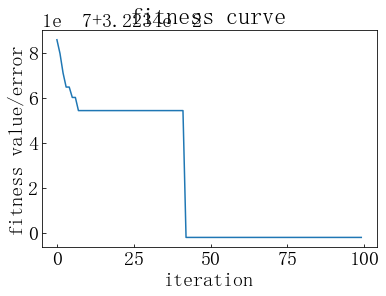

In [11]:
svr = []
prediction_test = []
actual_test = []

for imf in u:
    imf=imf.reshape(-1,1)
    imf=pd.DataFrame(imf)
    data_=imf.values
    data_ = data_.astype('float32')
    # 标准化/放缩 特征值在（0,1）之间
    scaler = StandardScaler()
    scaled = scaler.fit_transform(data_)
    
    n_in = 3
    n_out = 1
    # 构造一个20->1的监督学习型数据
    reframed = series_to_supervised(scaled, n_in=n_in, n_out=n_out)
    values=reframed.values
    
    #训练集和测试集的划分比例
    ratio=0.8 
    N=int(len(values) *ratio)
    train = values[:N, :]
    test = values[N:, :]

    # 划分输入和输出,split into input and outputs
    n_obs = n_in * n_features
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    train_y=train_y.reshape(-1,1)
    
    # In[] 参数设置
    hidden_sizes = [2]  #几个数就是几个隐含层，n个隐含层各自的节点就是[n1;n2;n3;n4;....nn]
    input_size = train_X.shape[1] #输入层节点数
    output_size= train_y.shape[1]#输出层节点数
    C=np.inf#L2正则化系数
    TF='sigmoid'#激活函数
    opts={'hidden_sizes':hidden_sizes,'input_size':input_size,'output_size':output_size,'C':C,'TF':TF}
    pop,trace=PSO(opts,train_X,train_y,test_X, test_y)
    
    # In[3]: 训练
    Net = DELM(input_size,hidden_sizes, output_size, C,TF) #construct a delm

    x=pop.flatten().copy()
    #对麻雀传人的参数进行解码

    nodes= [input_size]+hidden_sizes# 输入层与隐含层的节点数

    nelmae=len(nodes)-1

    para_num=[]

    for i in range(nelmae):
        if i==0:
            para_num += [nodes[i]*nodes[i+1]]
        else:
            para_num += [para_num[-1]+nodes[i]*nodes[i+1]]
        para_num += [para_num[-1]+nodes[i+1]]

    for i in range(nelmae):
        if i==0:
            IW=x[0:para_num[i]]
            b=x[para_num[i]:para_num[i+1]]
        else:
            IW=x[para_num[2*i-1]:para_num[2*i]]
            b=x[para_num[2*i]:para_num[2*i+1]]

        if nodes[i]>=nodes[i+1]:
            Net.elmae[i]['w']=spy.linalg.orth(IW.reshape(nodes[i],nodes[i+1]))
        else:
            Net.elmae[i]['w']=spy.linalg.orth(IW.reshape(nodes[i],nodes[i+1]).T).T
        Net.elmae[i]['b']=spy.linalg.orth(b.reshape(-1,1))
    Net.pretrain(train_X)#train elmae
    Net.train(train_X,train_y)#train delm
    svr.append(Net)

    # 作出预测
    yhat = Net.predict(test_X)
    yhat=yhat.reshape(-1,1)
    # 对预测结果进行反归一化
    inv_yhat = scaler.inverse_transform(yhat)
    prediction_test.append(inv_yhat)
    test_y=test_y.reshape(-1,1)
    inv_y = scaler.inverse_transform(test_y)
    actual_test.append(inv_y)


    #绘制适应度曲线
    plt.figure()
    plt.plot(trace)
    plt.title('fitness curve')
    plt.ylabel('fitness value/error')
    plt.xlabel('iteration')
    plt.show()

In [12]:
mean_pre_test = []                    

for i in range(0,len(prediction_test[0])):
    sum = 0
    for j in range(0,len(prediction_test)):
        sum = sum + prediction_test[j][i]
    
#     mean = sum/len(prediction_test) 
    mean_pre_test.append(sum)
        
mean_pre_test        

[array([69.14983838]),
 array([62.10420858]),
 array([23.23317333]),
 array([63.54251368]),
 array([59.60553365]),
 array([67.83888407]),
 array([47.32589933]),
 array([78.63538608]),
 array([73.15574075]),
 array([41.36884163]),
 array([24.04389792]),
 array([30.77479982]),
 array([38.57705633]),
 array([37.22283473]),
 array([52.59156248]),
 array([54.01359092]),
 array([66.01827612]),
 array([59.87837147]),
 array([37.19667033]),
 array([21.24224412]),
 array([65.34017766]),
 array([44.01221512]),
 array([50.6775747]),
 array([63.31618406]),
 array([46.24645291]),
 array([57.34336143]),
 array([26.13104709]),
 array([76.84353406]),
 array([22.83104853]),
 array([32.58888298]),
 array([32.8358851]),
 array([34.29887726]),
 array([51.50150728]),
 array([22.59573192]),
 array([70.17594947]),
 array([54.80610838]),
 array([41.41628343]),
 array([39.5966333]),
 array([57.85159731]),
 array([50.41196663]),
 array([38.66644028]),
 array([22.69855529]),
 array([39.26528998]),
 array([35.060

In [13]:
mean_actual_test = []

for i in range(0,len(actual_test[0])):
    sum = 0
    for j in range(0,len(actual_test)):
        sum = sum + actual_test[j][i]
    
#     mean = sum/len(actual_test)
    mean_actual_test.append(sum)
        
mean_actual_test    

[array([67.687836], dtype=float32),
 array([60.893204], dtype=float32),
 array([24.936432], dtype=float32),
 array([65.58691], dtype=float32),
 array([60.520435], dtype=float32),
 array([71.711136], dtype=float32),
 array([49.789494], dtype=float32),
 array([78.6303], dtype=float32),
 array([73.85271], dtype=float32),
 array([42.08354], dtype=float32),
 array([22.49472], dtype=float32),
 array([29.538277], dtype=float32),
 array([34.029366], dtype=float32),
 array([34.540188], dtype=float32),
 array([48.23792], dtype=float32),
 array([52.305294], dtype=float32),
 array([67.0561], dtype=float32),
 array([60.86489], dtype=float32),
 array([37.13389], dtype=float32),
 array([21.14384], dtype=float32),
 array([65.39081], dtype=float32),
 array([44.140118], dtype=float32),
 array([55.2398], dtype=float32),
 array([69.55323], dtype=float32),
 array([47.86802], dtype=float32),
 array([57.16407], dtype=float32),
 array([24.366068], dtype=float32),
 array([75.93216], dtype=float32),
 array([21.

In [14]:
# 计算RMSE
rmse = sqrt(mean_squared_error(mean_actual_test, mean_pre_test))
print('Test RMSE: %.7f' % rmse)
print('Test MAE: %.7f' % mean_absolute_error(mean_actual_test, mean_pre_test))
print('Test R2: %.7f' % r2_score(mean_actual_test, mean_pre_test))

Test RMSE: 2.1996883
Test MAE: 1.7813231
Test R2: 0.9797307


In [ ]:
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.sans-serif']=['Simhei']  #解决画图中文不显示问题
plt.figure(figsize=(6,4),dpi=600)
x=range(1, len(mean_pre_test) + 1)
plt.xticks(x[::50])
plt.tick_params(labelsize=10)  #改变刻度字体大小
plt.plot(x, mean_actual_test, linestyle="--",color='g',linewidth=1, label='Acture')
plt.plot(x, mean_pre_test,  color='red',linestyle="--",linewidth=1,label='VMD-PSO-DELM')
plt.rcParams.update({'font.size': 10})  #改变图例里面的字体大小
plt.legend(loc='upper right')
plt.xlabel("样本点",fontsize=10)
plt.ylabel("值",fontsize=10)
# plt.xlim(xmin=600,xmax=700)  #显示600-1000的值   局部放大有利于观察
# plt.savefig('台湾VMD-LSTM震级预测结果图.png')
plt.show()

In [ ]:
#保存预测结果
# savemat('vmd-hho-delm_result.mat',{'true':mean_actual_test,'pred':mean_pre_test})